# Using SVM + PCA for Digit Recognition

In Week 5, we have practiced using SVM to classify the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). In this lab, we'll build upon the most vanilla SVM model and experiment with performing PCA dimension reduction on the data before training the model.

Some brief review of the MNIST dataset:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn import datasets

# The digits dataset
digits = datasets.load_digits()

In [2]:
print(len(digits.images), len(digits.target))

1797 1797


The data that we are interested in is made of 8x8 images of digits, let's have a look at the first 10 images, stored in the `images` attribute of the dataset.  If we were working from image files, we could load them using `matplotlib.pyplot.imread`.  Note that each image must have the same size. For these images, we know which digit they represent: it is given in the `target` of the dataset.

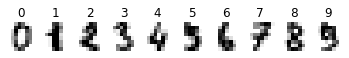

In [3]:
images_and_labels = list(zip(digits.images, digits.target))

for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('%i' % label)

In [4]:
n_samples = len(digits.images)
print(digits.images.shape)
data = digits.images.reshape((n_samples, -1))
print(data.shape)

(1797, 8, 8)
(1797, 64)


In the class, we will demonstrate how to use PCA to preprocess our image data, and how to use sklearn's `Pipeline` to streamline the steps in training and predicting data.

We will achieve the same results in two approaches:

1. Manually chaining the following preprocessing steps and the actual model training step:
    - Loading image data
    - Flattening image pixels
    - Standardizing pixel values
    - Perform PCA
    - Identify model
    - Model fitting

2. Taking advantage of sklearn's `Pipeline` class to easily chain steps together and set parameters for each step on the fly.

## What is Pipeline in sklearn?

Definition of pipeline class according to scikit-learn is:

> `Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit.`

### Loading image data

In [5]:
digits = datasets.load_digits()
print(f'Loaded {len(digits.images)} images and {len(digits.target)} labels.')

Loaded 1797 images and 1797 labels.


### Flattening image pixels

In [6]:
from sklearn.model_selection import train_test_split
images_train, images_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.2, stratify=digits.target)

In [7]:
def preprocess(images):
    """
    Input images is a (n_samples, 8, 8) matrix.
    To apply a classifier on this data, we need to flatten the image, i.e.,
    turn the data in a (samples, n_dim) matrix, where n_dim = 8*8

    :param images: a 3D matrix with shape (n_samples, 8, 8)
    :return: a flattened image matrix of shape (n_samples, 64)
    """
    print(f'Shape before preprocessing: {images.shape}')
    n_samples = images.shape[0]
    data = images.reshape((n_samples, -1))

    print(f'Shape after preprocessing: {data.shape}')

    return data

In [8]:
images_train = preprocess(images=images_train)
images_test = preprocess(images=images_test)

Shape before preprocessing: (1437, 8, 8)
Shape after preprocessing: (1437, 64)
Shape before preprocessing: (360, 8, 8)
Shape after preprocessing: (360, 64)


### Standardizing pixel values

Next, we want to transform all inputs by using `StandardScaler`.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

images_train_transformed = scaler.fit_transform(images_train)
images_test_transformed = scaler.transform(images_test)
images_test_transformed.shape

(360, 64)

### Perform PCA

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

images_train_transformed = pca.fit_transform(images_train_transformed)
images_test_transformed = pca.fit_transform(images_test_transformed)
images_test_transformed.shape

(360, 50)

### Identify model

In [25]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')

Now we are ready to create a `pipeline` object by providing with the list of steps. Here our steps are standard scalar, PCA and support vector machine. **These steps are list of tuples consisting of name and an instance of the transformer or estimator.** Let’s see the piece of code below for clarification.


In [26]:
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()), ('pca', PCA(n_components=50)), ('SVM', SVC(kernel='linear'))] # identify clearly the transformors and estimators.

pipeline = Pipeline(steps) # define the pipeline object.

In [27]:
pipeline

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('SVM',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

You can set the parameters using the names issued. For instance, fit using n_components=30 for PCA

In [29]:
pipeline.set_params(pca__n_components=30)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=30,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('SVM',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

### Fitting data

In [30]:
pipeline.fit(images_train_transformed, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=30,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('SVM',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [31]:
pipeline.predict(images_test_transformed)

array([1, 2, 3, 0, 0, 2, 1, 2, 6, 3, 3, 2, 3, 4, 2, 2, 4, 1, 1, 3, 6, 0,
       3, 9, 7, 7, 1, 5, 7, 4, 1, 8, 8, 1, 8, 1, 1, 3, 3, 2, 4, 7, 5, 6,
       8, 7, 7, 0, 4, 2, 5, 1, 1, 5, 9, 2, 4, 3, 5, 2, 4, 0, 1, 8, 1, 2,
       4, 6, 6, 5, 5, 8, 0, 4, 1, 5, 8, 2, 7, 6, 6, 6, 4, 5, 3, 8, 9, 9,
       7, 3, 6, 3, 3, 7, 2, 6, 8, 4, 9, 6, 5, 2, 9, 5, 5, 4, 9, 9, 3, 2,
       2, 4, 3, 1, 4, 6, 5, 0, 2, 9, 9, 2, 6, 2, 2, 5, 4, 1, 9, 4, 4, 4,
       0, 3, 8, 9, 8, 5, 6, 1, 8, 5, 0, 1, 7, 7, 4, 8, 5, 2, 7, 7, 9, 9,
       2, 8, 2, 2, 2, 9, 9, 8, 2, 8, 2, 3, 3, 8, 1, 5, 8, 3, 1, 1, 7, 6,
       6, 9, 1, 8, 4, 2, 3, 7, 6, 8, 1, 4, 3, 3, 0, 4, 7, 5, 2, 6, 2, 2,
       7, 5, 9, 4, 1, 2, 4, 5, 9, 8, 9, 3, 6, 2, 2, 1, 6, 7, 7, 6, 7, 2,
       1, 6, 2, 2, 9, 8, 8, 2, 9, 2, 7, 4, 0, 6, 5, 4, 4, 5, 1, 0, 6, 1,
       9, 0, 3, 8, 6, 4, 1, 2, 1, 5, 5, 1, 3, 3, 8, 6, 9, 2, 4, 6, 5, 9,
       1, 1, 1, 9, 9, 1, 2, 1, 4, 3, 7, 9, 5, 9, 8, 7, 3, 1, 7, 5, 7, 8,
       5, 1, 9, 3, 7, 2, 0, 5, 7, 8, 0, 6, 2, 6, 0,

## Why need pipeline?

In a typical machine learning workflow you will need to apply all these transformations at least twice. Once when training the model and again on any new data you want to predict on. Of course you could write a function to apply them and reuse that but you would still need to run this first and then call the model separately. **Scikit-learn pipelines are a tool to simplify this process.** They have several key benefits:
1. They make your workflow much easier to read and understand.
2. They enforce the implementation and order of steps in your project.
3. These in turn make your work much more reproducible.


## Model selection
A pipeline can also be used during the model selection process. The following example code loops through a number of scikit-learn classifiers applying the transformations and training the model.

In [33]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

for classifier in classifiers:
    steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)), ('classifier', classifier)]
    pipe = Pipeline(steps)
    pipe.fit(images_train_transformed, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(images_test_transformed, y_test))
    print('----')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.153
----
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
model score: 0.092
----
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, probability=True, random_state=None,
      shrinking=True, tol=0.001, verbose=False)
model score: 0.181
----
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples

/Users/jodie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
model score: 0.133
----
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
model score: 0.200
----
